# VALUE vs GROWTH DETECTION

This notebook contains all the code that will produce a model/signal to predict the optimum shift between value or growth investing.

_IMPORTS_

In [2]:
import os
import json
import pickle
import dotenv
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### _LOAD DATA_

In [3]:
root_dir = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(root_dir, "data")
dotenv_file = os.path.join(root_dir, '.env')

#loading all etfs data
etfs_dict = {}
for f in os.listdir(os.path.join(DATA_DIR, "etf_data")):
    if f.startswith("SPY"):
        etfs_dict[f.strip(".csv")] = pd.read_csv(os.path.join(DATA_DIR, "etf_data", f))

with open (os.path.join(DATA_DIR, "etf_data", "us_etfs_list.pkl"), "rb") as f:
    etfs_list : dict = pickle.load(f)

#Load Commodities Futures Prices: .csv
commodities_dict = {}
commodities_files = os.listdir(os.path.join(DATA_DIR, "commodities"))
for f in commodities_files:
    commodities_dict[f.strip(".csv")] = pd.read_csv(os.path.join(DATA_DIR, "commodities", f))

#Load Currencies Prices: .csv
currencies_dict = {}
currencies_files = os.listdir(os.path.join(DATA_DIR, "currencies"))
for f in currencies_files:
    currencies_dict[f.strip(".csv")] = pd.read_csv(os.path.join(DATA_DIR, "currencies", f))

#FEDFUNDS and BALANCE: .pkl
macro_files = os.listdir(os.path.join(DATA_DIR, "macro_data"))
with open(os.path.join(DATA_DIR, "macro_data", "macro_data.pkl"), "rb") as f:
    macro_dict = pickle.load(f)


### EDA & Feature Eng

_Create Dataframes_

In [4]:
start, end = "2014-05-01", "2024-05-01"
daterange = pd.date_range(start=start, end=end, freq="d").strftime("%Y-%m-%d")
period = 30

etfs = [i[:-4] for i in os.listdir(os.path.join(DATA_DIR, "etf_data")) if i.startswith("SPY")]
etfs_df = pd.concat(
    [pd.read_csv(os.path.join(DATA_DIR, "etf_data",f"{i}.csv"),index_col="Date") for i in etfs],
    axis=1,
)
etfs_df.columns = etfs
etfs_df = np.log(etfs_df / etfs_df.shift(period))
etfs_df = etfs_df[(etfs_df.index >= start) & (etfs_df.index <= end)]
#-------------------------------------------------------------------------------------------------------------
currencies = [i[:-4] for i in os.listdir(os.path.join(DATA_DIR, "currencies"))]
curr_df = pd.concat(
    [pd.read_csv(os.path.join(DATA_DIR, "currencies",f"{i}.csv"), index_col="Date") for i in currencies],
    axis=1,
)
curr_df.columns = currencies
curr_df = np.log(curr_df/curr_df.shift(period))
curr_df = curr_df[(curr_df.index >= start) & (curr_df.index <= end)]
# #-------------------------------------------------------------------------------------------------------------
macro_ind = [i[:-4] for i in os.listdir(os.path.join(DATA_DIR, "macro_data")) if i.endswith(".csv")]
macro_df = pd.read_csv(os.path.join(DATA_DIR,"macro_data", "FEDFUNDS.csv"),index_col="Date")
macro_df = np.log(macro_df/macro_df.shift(1))
macro_df.columns = macro_ind
# #-------------------------------------------------------------------------------------------------------------
comm = [i[:-4] for i in os.listdir(os.path.join(DATA_DIR, "commodities")) if i.endswith(".csv")]
commodities_df = pd.concat(
    [pd.read_csv(os.path.join(DATA_DIR, "commodities", f"{i}.csv"),index_col="Date")["Close"] for i in comm],
    axis=1,
)
commodities_df = np.log(commodities_df/commodities_df.shift(period))
commodities_df = commodities_df[(commodities_df.index >= start) & (commodities_df.index <= end)]
commodities_df.columns = comm
# #-------------------------------------------------------------------------------------------------------------
#Set common indexes
all_data = pd.DataFrame(index=daterange)
all_data = all_data.merge(etfs_df, left_index=True, right_index=True, how="left")
all_data = all_data.merge(commodities_df, left_index=True, right_index=True, how="left")
all_data = all_data.merge(curr_df, left_index=True, right_index=True, how="left")
all_data = all_data.merge(macro_df, left_index=True, right_index=True, how="left")
all_data.index.name = "Date"
all_data.fillna(method="ffill", inplace=True)

all_data["midpoint"] = (all_data["SPYG"] + all_data["SPYV"]) / 2


_Visualize Data_

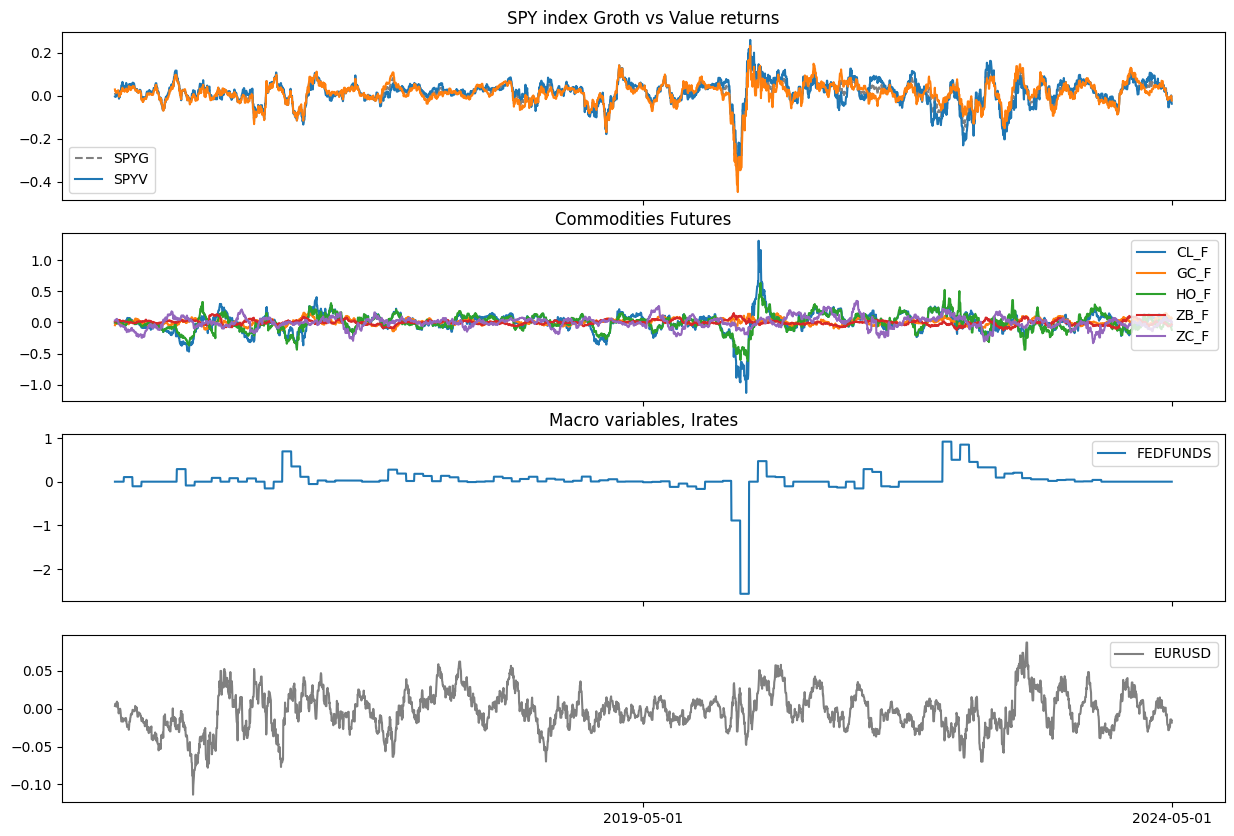

In [5]:
fig, axs = plt.subplots(nrows=4, figsize=(15, 10), sharex=True)

#ETFs
SPYG = all_data.SPYG
SPYV = all_data.SPYV
SPY_midpoint = (SPYG + SPYV) / 2
axs[0].plot(SPY_midpoint, color="grey", linestyle="dashed")
axs[0].plot(all_data["SPYG"])
axs[0].plot(all_data["SPYV"])
axs[0].legend(["SPYG", "SPYV"])
axs[0].set_title("SPY index Groth vs Value returns")

#Commodities
for i in comm:
    axs[1].plot(all_data[i])
axs[1].legend(comm)
axs[1].set_title("Commodities Futures")

#Macro
axs[2].plot(all_data["FEDFUNDS"])
axs[2].legend(macro_df.columns)
axs[2].set_title("Macro variables, Irates")

#currencies
axs[3].plot(all_data["EURUSD"], color="grey")
axs[3].legend(curr_df.columns);

plt.xticks(ticks=all_data.index[::-int(len(all_data)/2)])
plt.savefig(os.path.join(root_dir,"charts", "all_features_history.png"))

#### _Statistical Measures_

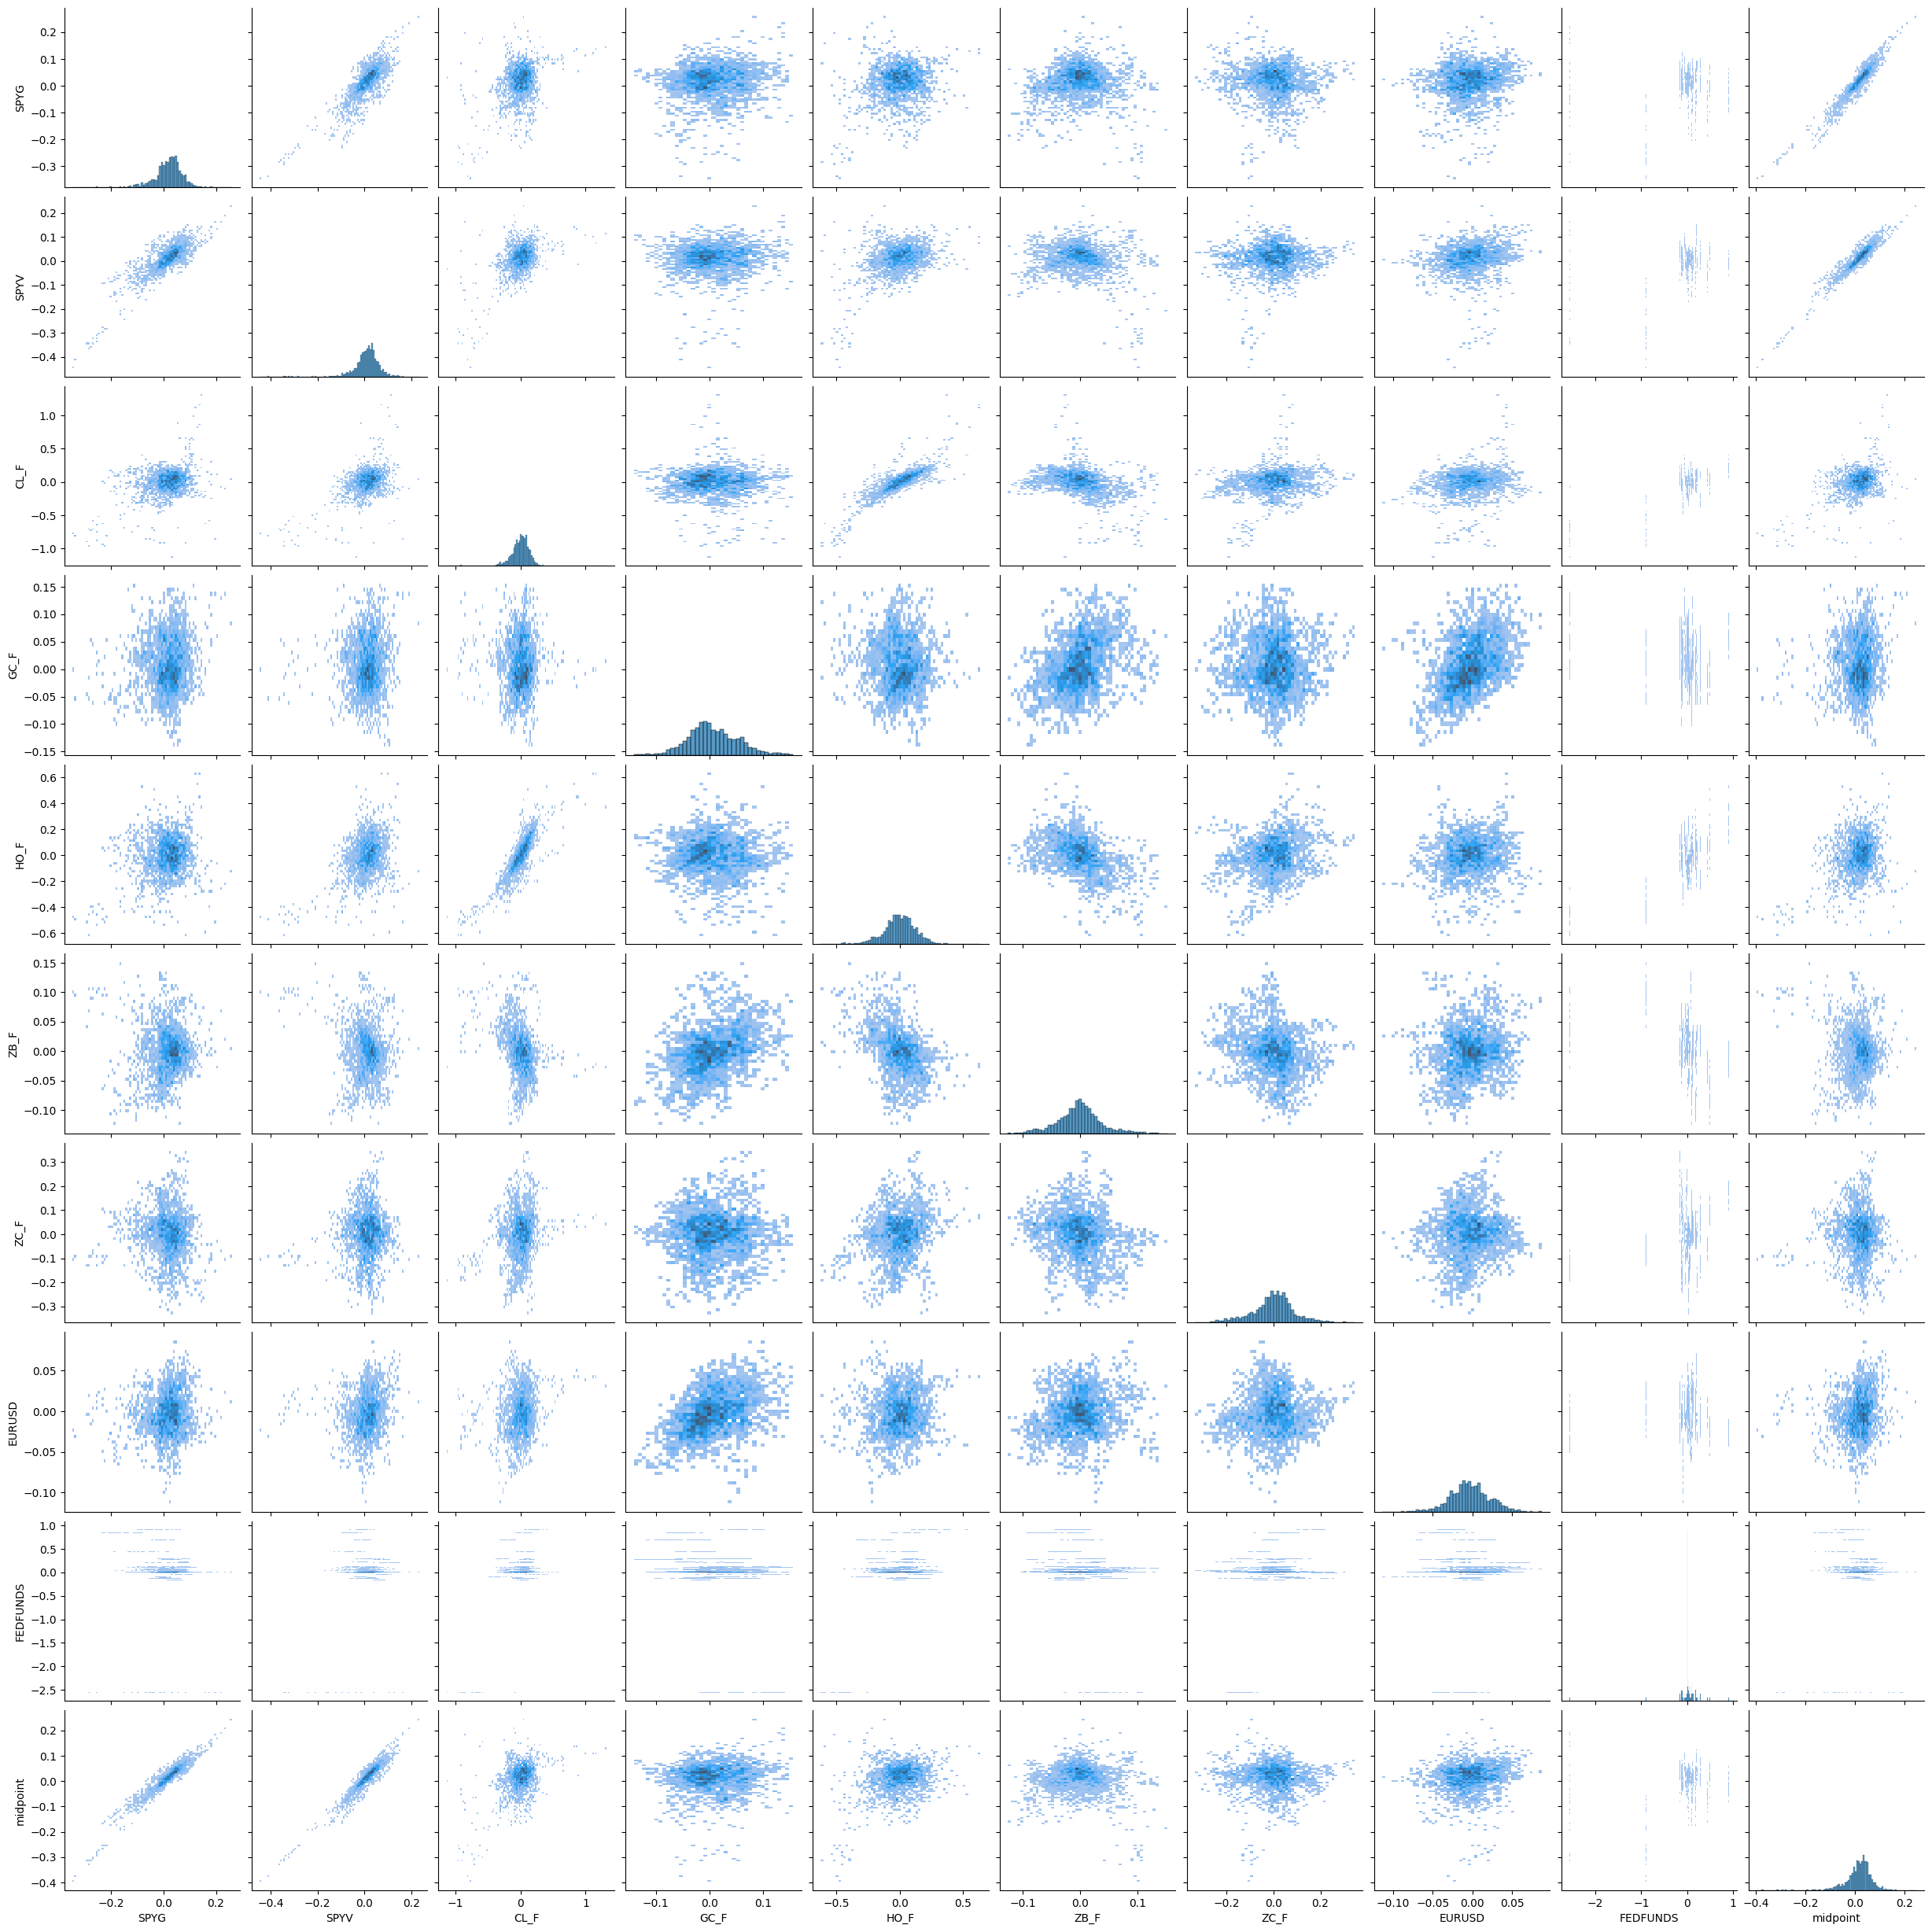

In [6]:
sns.pairplot(all_data, kind="hist")

_Correlation_

<Axes: >

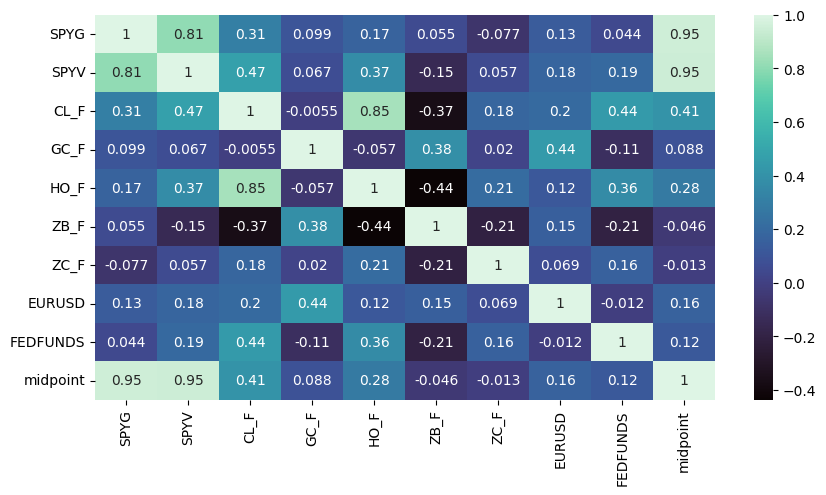

In [7]:
fig = plt.figure(figsize=(10, 5))
sns.heatmap(all_data.corr(method="pearson"),cmap="mako",annot=True)

### _Clasification of Growth/Value Moments_

In [8]:
# seperate both investing styles using the midpoint:
# 1 for growth 0 for value
period = 15
all_data["momment"] = (SPYG > SPY_midpoint).astype(int)
all_data["momment"].shift(period)
all_data.dropna(inplace=True)
y = all_data["momment"]
not_features = ["SPYG", "SPYV", "momment", "midpoint"]
features = [i for i in all_data.columns if i not in not_features]
X = all_data[features]

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial import distance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

In [10]:
knn = KNeighborsClassifier()
cv = GridSearchCV(estimator=knn, param_grid={'metric':["cosine","euclidean","l1","l2"],'n_neighbors': range(1, 31)})
cv.fit(X_train, y_train)
predictions = cv.predict(X_test)

In [11]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.62      0.33      0.43       345
           1       0.58      0.82      0.68       386

    accuracy                           0.59       731
   macro avg       0.60      0.58      0.56       731
weighted avg       0.60      0.59      0.56       731



### _Backtesting_

_US Backtest_

In [12]:
# Calculate cumulative returns for independent assets
from tabulate import tabulate

SPYG_cret = SPYG[y_test.index].cumsum()
SPYV_cret = SPYV[y_test.index].cumsum()
STRAT_cret = []
for i in range(len(SPYG_cret)):
    if predictions[i] == 1:
        STRAT_cret.append(SPYG[y_test.index][i])
    if predictions[i] == 0: 
        STRAT_cret.append(SPYV[y_test.index][i])

STRAT_cret = np.cumsum(STRAT_cret)
results = [
    ["SPYV ETF only", SPYV_cret.values[-1]], 
    ["SPYG ETF only", SPYG_cret.values[-1]],
    ["Value/Growth Momment Classification Strategy", STRAT_cret[-1]]
]

headers = ["Strategies","cumulative returns"]
print(tabulate(results, headers, tablefmt="github"))

| Strategies                                   |   cumulative returns |
|----------------------------------------------|----------------------|
| SPYV ETF only                                |              9.42674 |
| SPYG ETF only                                |              6.93742 |
| Value/Growth Momment Classification Strategy |             11.1718  |


_visualize results_

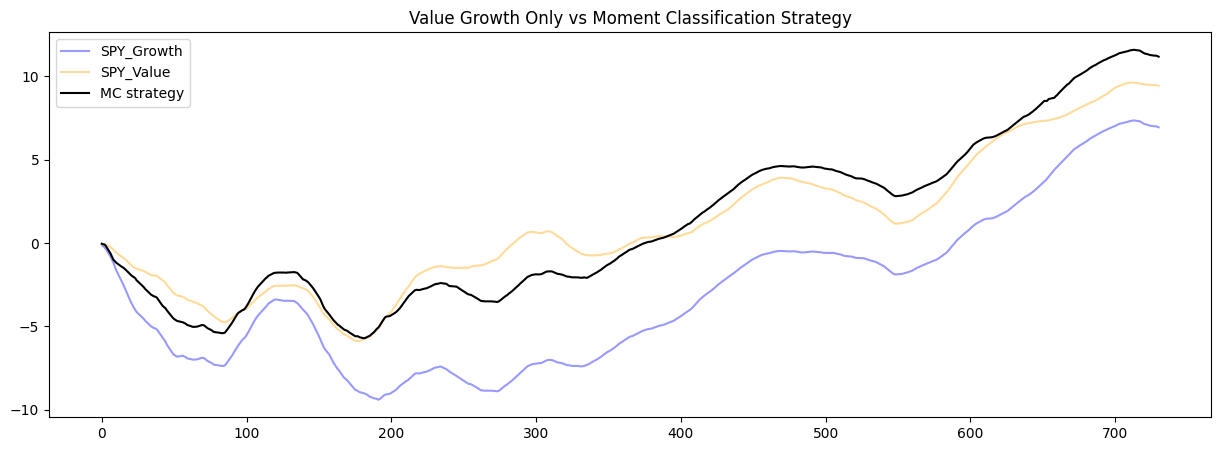

In [13]:
fig = plt.figure(figsize=(15,5))

plt.plot(SPYG_cret.values, color="blue", alpha=0.4)
plt.plot(SPYV_cret.values, color="orange", alpha=0.4)
plt.plot(STRAT_cret, color="black")
tittle = "Value Growth Only vs Moment Classification Strategy"
plt.title(tittle)
plt.legend(["SPY_Growth", "SPY_Value", "MC strategy"])
plt.savefig(os.path.join(root_dir, "charts", f"{tittle.replace(" ", "_")}.png"))

_Backtesting with Long/Short Value etf in Europe_

| Strategies      | returns   |
|-----------------|-----------|
| Asset ROI       | 40.40%    |
| Strategy Returs | 51.04%    |


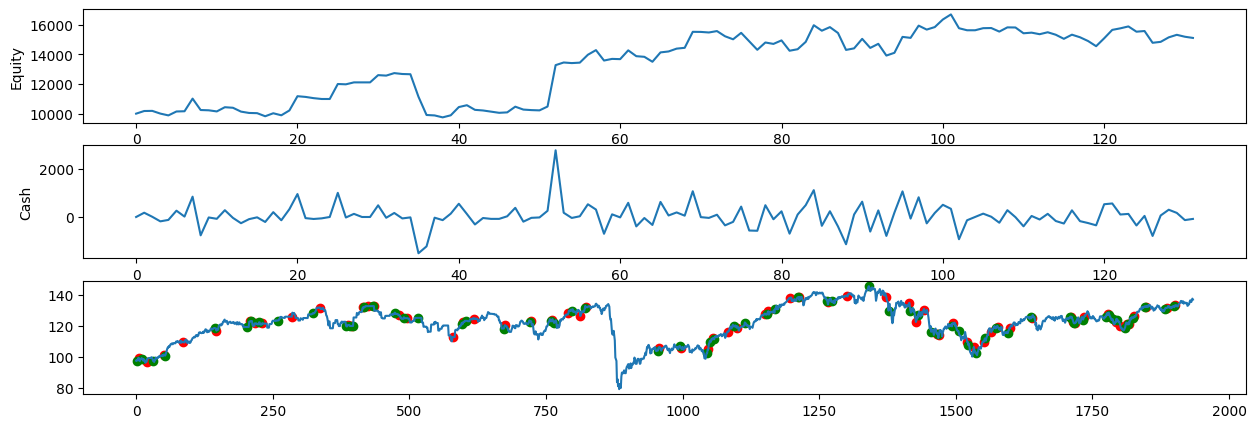

In [57]:
valu_etf = pd.read_csv(os.path.join(DATA_DIR, "etf_data", "VALU.DE.csv")).set_index("Date")
valu_etf["returns"] = np.log(valu_etf["Close"]/valu_etf["Close"].shift(1)) #period = 5
valu_etf.dropna(inplace=True)

X_eu = X[X.index.isin(valu_etf.index)]
europe_predictions = cv.predict(X_eu)
X_eu["predictions"] = europe_predictions
valu_etf = valu_etf[valu_etf.index.isin(X_eu.index)]
#making predictions:

buy_idx = np.where(europe_predictions == 0)
sell_idx = np.where(europe_predictions == 1)

class my_backtester:
    
    def __init__(self, cash, data, buy_and_hold_days) -> None:
        self.buy_and_hold_days = buy_and_hold_days
        self.equity = cash
        self.cash = cash
        self.data = data
        self.n = len(data)
        self.last_entry = 0
        self.current_signal = None
        self.position = {"short": 0, "long": 0}
        self.history = {"equity":[], "cash": [], "entries":[]}

    def run(self):
        i = 0
        while i < self.n:
            self.current_signal = self.data.predictions[i]
            Q = 1 * self.equity
            if self.current_signal == 1 and self.position["short"] == 0 and i % self.buy_and_hold_days == 0:
                if self.position["long"] != 0:
                    value = ((self.data.Close[i] - self.last_entry) / self.last_entry) \
                        * (self.position["long"] * self.last_entry)
                    self.equity += value
                    self.cash = self.equity
                    self.position["long"] = 0
                self.position["short"] = int((Q) / self.data.Close[i])
                self.last_entry = self.data.Close[i]
                self.cash -= Q
                i+=1
                self.history["entries"].append((self.current_signal, i))
                self.history["equity"].append(self.equity)
                self.history["cash"].append(self.cash)
                continue
            if self.current_signal == 0 and self.position["long"] == 0 and i % self.buy_and_hold_days == 0:
                if self.position["short"] != 0:
                    value = ((self.last_entry - self.data.Close[i]) / self.data.Close[i]) \
                        * (self.position["short"] * self.last_entry)
                    self.equity += value
                    self.cash = self.equity
                    self.position["short"] = 0
                self.position["long"] = int((Q) / self.data.Close[i])
                self.last_entry = self.data.Close[i]
                self.cash -= Q
                i+=1
                self.history["entries"].append((self.current_signal,i))
                self.history["equity"].append(self.equity)
                self.history["cash"].append(self.cash)
                continue
            else:
                i+=1

        returns = (((self.history["equity"][-1] - self.history["equity"][0]) / self.history["equity"][0])*100)
        asset_returns = ((self.data["Close"][-1] - self.data["Close"][0]) / self.data["Close"][0])*100
        results = [
            ["Asset ROI", f"{format(asset_returns,'.2f')}%"],
            ["Strategy Returs", f"{format(returns,'.2f')}%"],
        ]
        headers = ["Strategies","returns"]
        print(tabulate(results, headers, tablefmt="github"))
        
    def visualize(self):
        fig, ax = plt.subplots(nrows=3, figsize=(15, 5))
        ax[0].plot(self.history["equity"])
        ax[0].set_ylabel("Equity")
        ax[1].plot(self.history["cash"])
        ax[1].set_ylabel("Cash")
        ax[2].plot(self.data.Close.values)
        entries_buy = [i[1] for i in self.history["entries"] if i[0] == 0]
        entries_sell = [i[1] for i in self.history["entries"] if i[0] == 1]
        ax[2].scatter(entries_sell, self.data["Close"][entries_sell],color="red")
        ax[2].scatter(entries_buy, self.data["Close"][entries_buy],color="green")
data = pd.concat(
    [
        valu_etf["Close"],
        X_eu["predictions"]
    ],
    axis=1, 
)

backtester = my_backtester(cash=10000, data=data, buy_and_hold_days= 2)
returns = backtester.run()
backtester.visualize()